In [20]:
from utils import *

vol_file = '../Analysis/depreciated/analysis_sections_gain.csv'
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
dat_xls_file = dat_xls_file.reset_index()
t_pre = 100 # time window pre-swim
t_post = 350 # time window post-swim
t_label = np.arange(-t_pre, t_post)/300
t_sig = 240

k_ = gaussKernel(sigma=5)
k_sub = gaussKernel(sigma=5)
ave_low_list = []
ave_high_list = []
p_mat = []
fish_id = []
pre_swim_act = []
swim_type = []
swim_type_max = []

print('Collect data')
for ind, row in dat_xls_file.iterrows():    
    folder = row['folder']
    fish = row['fish']
    task_type = row['task']    
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz')
    task_period = _['task_period'] 
    swim_starts = _['swim_starts'] 
    trial_valid = np.ones(len(swim_starts)).astype('bool')
    for n, n_swim in enumerate(swim_starts[:-1]):        
        # examine the swim with short inter-swim-interval
        if swim_starts[n+1] - n_swim < t_sig:    
            trial_valid[n] = False
    
    _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}_swim_voltr_dat.npz')
    spk_swim = _['spk_swim']
    
    for n_cell in range(spk_swim.shape[0]):        
        spk_list = spk_swim[n_cell]
        tmp = []
        for n_spk in spk_list:
            tmp.append(smooth(n_spk, k_))
        spk_list = np.array(tmp)
        non_trial = np.isnan(spk_list).sum(axis=-1)==0
        trial_valid = trial_valid & non_trial
        gain_stat = np.zeros(t_pre+t_post)
        for ntime in range(-t_pre, t_post):
            val, pval= ranksums(spk_list[(task_period==1) & trial_valid, t_pre+ntime], 
                                spk_list[(task_period==2) & trial_valid, t_pre+ntime])
            gain_stat[t_pre+ntime] = np.sign(-val) * pval
        p_mat.append(gain_stat)
        ave_low_list.append(spk_list[(task_period==1) & trial_valid].mean(axis=0)*300)
        ave_high_list.append(spk_list[(task_period==2) & trial_valid].mean(axis=0)*300)
        pre_swim_act.append(spk_list[:, :t_pre-30].mean(axis=1))
        swim_type.append(task_period)
        fish_id.append(folder+fish[:5])
        swim_type_max.append(task_period.max())

ave_low_list = np.array(ave_low_list)
ave_high_list = np.array(ave_high_list)
swim_type_max = np.array(swim_type_max)

Collect data
number of cells 32
number of fish 8


In [61]:
from glob import glob

In [68]:
selected_fish = np.unique(np.array(fish_id)[sel_ind])

swim_bout_len = []
for n_fish in selected_fish:
    folder = n_fish[:8]
    fish = n_fish[8:]
    file_ = glob(f'../Analysis/swim_power/{folder}_{fish}*before_swim_dat.npz')[0]
    _ = np.load(file_, allow_pickle=True)
    swim_starts = _['swim_starts']
    swim_ends = _['swim_ends']
    swim_bout_len.append(np.diff(swim_starts).mean()/300)

In [70]:
np.mean(swim_bout_len)*10

15.17090133276123

In [71]:
np.std(swim_bout_len)*10

4.858911950579269

In [38]:
sig_mat = np.abs(p_mat)[:, t_pre-30:(t_pre+300)]<0.05
sel_ind = (sig_mat.sum(axis=-1)>5) & (swim_type_max<3) & (ave_low_list[:, (t_pre+100):(t_pre+300)].sum(axis=1)<ave_high_list[:, (t_pre+100):(t_pre+300)].sum(axis=1))
print(f'number of cells {sel_ind.sum()}')
print(f'number of fish {len(np.unique(np.array(fish_id)[sel_ind]))}')

lh_pre = []
hl_pre = []

for n_cell in np.where(sel_ind)[0]:
    act_ = pre_swim_act[n_cell]
    n_swims = swim_type[n_cell]
    epoch_start = np.r_[0, np.diff(n_swims)]
    epoch_start_lh = np.where(epoch_start==-1)[0]
    epoch_start_lh = epoch_start_lh[:-1]
    lh_trial = np.zeros((len(epoch_start_lh), 10))
    for n in range(10):
        lh_trial[:, n-3] = act_[epoch_start_lh+n-3]
    
    epoch_start_hl = np.where(epoch_start==1)[0]
    epoch_start_hl = epoch_start_hl[:-1]
    hl_trial = np.zeros((len(epoch_start_hl), 10))
    for n in range(10):
        hl_trial[:, n-3] = act_[epoch_start_hl+n-3]

    # print(n_cell)
    lh_pre.append(lh_trial.mean(axis=0))
    hl_pre.append(hl_trial.mean(axis=0))
lh_pre = np.array(lh_pre)
hl_pre = np.array(hl_pre)

number of cells 36
number of fish 8


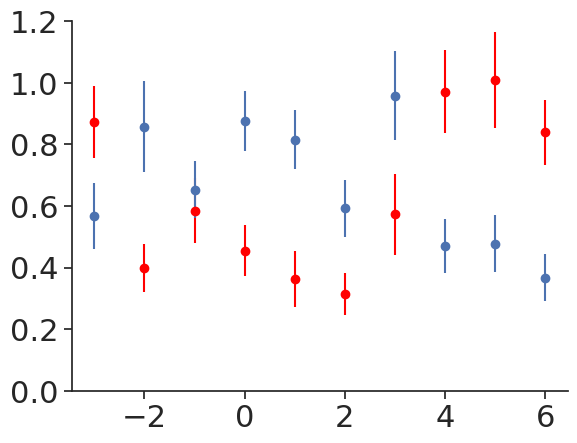

In [50]:
ave_ = lh_pre.mean(axis=0)
std_ = lh_pre.std(axis=0)/6
# order_ = np.argsort(ave_)
order_ = np.arange(10)

plt.errorbar(np.arange(-3, 7), ave_[order_], std_[order_], color='red', ls='none', marker='o')

ave_ = hl_pre.mean(axis=0)
std_ = hl_pre.std(axis=0)/6
# order_ = np.argsort(-ave_)
order_ = np.arange(10)

plt.errorbar(np.arange(-3, 7), ave_[order_], std_[order_], color='b', ls='none', marker='o')

sns.despine()
plt.ylim([0, 1.2])
plt.savefig('pre_swim_rate.pdf')